## Libraries and Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install torch_utils

  Created wheel for torch-utils: filename=torch_utils-0.1.2-cp36-none-any.whl size=6191 sha256=f800c1550a7d53023b6f4ff2e8d5cc5cfbd7215e783434271cacf7431fdcdcd8
  Stored in directory: /root/.cache/pip/wheels/95/61/06/139d254fa820bc1e45087dba1d719bc7d4007aec98905179c7
Successfully built torch-utils


In [ ]:
%cd gdrive/My\ Drive/Colab\ Notebooks/Case_Study_2

/content/gdrive/My Drive/Colab Notebooks/Case_Study_2


In [ ]:
# import modules
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler 
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Random Oversampling

### Data Preprocessing 

In [ ]:
# import data
creditcard = pd.read_csv('data/creditcard.csv')

#separate features and labels
X = creditcard.iloc[:,0:30]
y = creditcard.iloc[:,-1]

In [ ]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(data = X_test)

#oversample data to achieve 50/50 ration between fraud and nonfraud cases
ros_50_50 = RandomOverSampler(sampling_strategy='minority')
X_balanced, y_balanced = ros_50_50.fit_resample(X_train, y_train)
X_balanced = pd.DataFrame(data = X_balanced)
y_balanced = pd.DataFrame(data = y_balanced)

#create splits for validation data
X_train, X_validation, y_train, y_validation = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
to_use = list(range(0,30))

# training set
train_X = torch.tensor(X_train.values).float()
train_Y = torch.tensor(y_train.values).long()

# validation set
validation_X = torch.tensor(X_validation.values).float()
validation_Y = torch.tensor(y_validation.values).long()

# prediction set
test_X = torch.tensor(X_test.values).float()

In [ ]:
train_Y = torch.flatten(train_Y)
validation_Y = torch.flatten(validation_Y)

### Baseline Model

In [ ]:
#device = torch.device("cuda")
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} 
# prepare training data loader
train_ds = TensorDataset(train_X,train_Y)
validate_ds = TensorDataset(validation_X,validation_Y)

batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True,**kwargs)

validate_dl = DataLoader(validate_ds, batch_size, shuffle=True,**kwargs)

# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        self.fc1 = nn.Linear(input_d,hidden_d)
        self.fc2 = nn.Linear(hidden_d,hidden_d)
        self.fc3 = nn.Linear(hidden_d,output_d)
        #self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        #out = self.dropout1(out)
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return torch.sigmoid(out)

# define dimensions
input_d = len(to_use)
hidden_d = 1
output_d = 2

# set up the model
model = bmodel(input_d, hidden_d, output_d).to(device)

# define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-3)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define the training function
def train(train_loader,model,device,loss_fn,opt):
    model.train()

    losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        #targets = targets.unsqueeze(dim=0)
        
        # generate predictions
        pred = model(inputs)
        
        loss = loss_fn(pred, targets)

        # record loss
        losses.update(loss.data.item())

        # perform gradient descent
        opt.zero_grad()
        loss.backward()
        opt.step()

    return losses.avg

# define the validation function
def validate(val_loader, model, device, loss_fn):
    model.eval()
    with torch.no_grad():
        losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

        for batch_idx, (inputs,targets) in enumerate(val_loader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #targets = targets.unsqueeze(1)
            outputs = model(inputs)
            loss = loss_fn(outputs , targets)

            losses.update(loss.data.item())

    return losses.avg

# define the main function
def fit(num_epochs, model, loss_fn, opt):

    best_loss = 1e9
    is_best = False
    out_train_loss = []
    out_validate_loss = []

    for epoch in range(1,num_epochs+1):
        train_loss = train(train_dl,model,device,loss_fn,opt)
        validation_loss = validate(validate_dl, model,device, loss_fn)

        is_best = validation_loss < best_loss
        best_loss = min(validation_loss,best_loss)

        out_train_loss.append(train_loss)
        out_validate_loss.append(validation_loss)

        if is_best:
            torch.save(model.state_dict(), 'data/best_nn.pt')

        if epoch % 5 == 0:
            print("[%d/%d] training loss: %0.3f, validation loss: %.3f"
                  % (epoch,num_epochs,train_loss,validation_loss))

    print("Best validation loss (%.03f): %.03f" % (epoch,best_loss))
    return out_train_loss, out_validate_loss

#### Train Model

In [ ]:
out_train_loss, out_validate_loss = fit(125, model, loss_fn, opt)

[5/125] training loss: 0.484, validation loss: 0.475
[10/125] training loss: 0.434, validation loss: 0.431
[15/125] training loss: 0.412, validation loss: 0.410
[20/125] training loss: 0.399, validation loss: 0.399
[25/125] training loss: 0.392, validation loss: 0.391
[30/125] training loss: 0.386, validation loss: 0.386
[35/125] training loss: 0.383, validation loss: 0.383
[40/125] training loss: 0.380, validation loss: 0.380
[45/125] training loss: 0.377, validation loss: 0.378
[50/125] training loss: 0.375, validation loss: 0.376
[55/125] training loss: 0.374, validation loss: 0.374
[60/125] training loss: 0.372, validation loss: 0.373
[65/125] training loss: 0.371, validation loss: 0.372
[70/125] training loss: 0.370, validation loss: 0.371
[75/125] training loss: 0.369, validation loss: 0.370
[80/125] training loss: 0.368, validation loss: 0.369
[85/125] training loss: 0.368, validation loss: 0.368
[90/125] training loss: 0.367, validation loss: 0.368
[95/125] training loss: 0.366

#### Validation

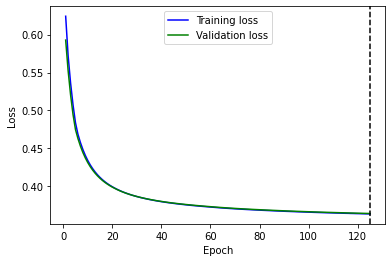

In [ ]:
# plot the training and validation loss: rmse
plot_data = {'Epoch': list(range(1,126)),
             'TrainLoss': [x for x in out_train_loss],
             'ValidateLoss': [x for x in out_validate_loss] }

plot_data = pd.DataFrame(plot_data)

# find the best epoch
index_min = plot_data['ValidateLoss'].idxmin()

# plot
plt.plot('Epoch','TrainLoss',data=plot_data,color="blue",label='Training loss')
plt.plot('Epoch','ValidateLoss',data=plot_data,color="green",label='Validation loss')
#plt.axhline(y=0.7, color='red', linestyle='-')
plt.axvline(x=index_min+1, color='k', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# prediction in the validation set
model.load_state_dict(torch.load('data/best_nn.pt'))
model.eval()
with torch.no_grad():
    preds = model(validation_X.cpu()) 

ans = []
#Pick the class with maximum weight
for t in preds:
  if t[0]>t[1]:
    ans.append(0)
  else:
    ans.append(1)

In [ ]:
#compute accuracy score
acc = accuracy_score(validation_Y, ans)
print("Accuracy Score: %.3f" % (acc))

Accuracy Score: 0.956


In [ ]:
#compute confusuion matrix and false positive and negative rates
con_mat = confusion_matrix(validation_Y, ans)
fn_rate = con_mat[1][0] /(con_mat[1][0] + con_mat[1][1])
fp_rate = con_mat[0][1] /(con_mat[0][0] + con_mat[0][1])
print("False Negative Rate: %.3f, False Positive Rate: %.3f" % (fn_rate, fp_rate))

False Negative Rate: 0.062, False Positive Rate: 0.025


In [ ]:
con_mat

array([[44209,  1189],
       [ 2581, 43002]])

#### Prediction

In [ ]:
# predict in the prediction set
model.eval()
with torch.no_grad():
    output = model(test_X.cpu())

out_d = pd.DataFrame(output)

    

In [ ]:
ans_test = []
#Pick the class with maximum weight
for t in output:
  if t[0]>t[1]:
    ans_test.append(0)
  else:
    ans_test.append(1)

In [ ]:
#compute accuracy score
acc_test = accuracy_score(y_test, ans_test)
print("Accuracy Score: %.3f" % (acc_test))

Accuracy Score: 0.974


In [ ]:
#compute confusion matrix as well as false positive and false negative rates
con_mat_test = confusion_matrix(y_test, ans_test)
fn_rate_test = con_mat_test[1][0] /(con_mat_test[1][0] + con_mat_test[1][1])
fp_rate_test = con_mat_test[0][1] /(con_mat_test[0][0] + con_mat_test[0][1])
print("False Negative Rate: %.3f, False Positive Rate: %.3f" % (fn_rate_test, fp_rate_test))

False Negative Rate: 0.082, False Positive Rate: 0.026


In [ ]:
con_mat_test

array([[55387,  1477],
       [    8,    90]])

### Model Improvements

In [ ]:
#device = torch.device("cuda")
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} 
# prepare training data loader
train_ds = TensorDataset(train_X,train_Y)
validate_ds = TensorDataset(validation_X,validation_Y)

batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True,**kwargs)

validate_dl = DataLoader(validate_ds, batch_size, shuffle=True,**kwargs)

# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        self.fc1 = nn.Linear(input_d,hidden_d)
        self.fc2 = nn.Linear(hidden_d,hidden_d)
        self.fc3 = nn.Linear(hidden_d, output_d)
        self.dropout1 = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout1(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

# define dimensions
input_d = len(to_use)
hidden_d = len(to_use)
output_d = 2

# set up the model
model = bmodel(input_d, hidden_d, output_d).to(device)

# define optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define the training function
def train(train_loader,model,device,loss_fn,opt):
    model.train()

    losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        #targets = targets.unsqueeze(dim=0)
        
        # generate predictions
        pred = model(inputs)
        
        loss = loss_fn(pred, targets)

        # record loss
        losses.update(loss.data.item())

        # perform gradient descent
        opt.zero_grad()
        loss.backward()
        opt.step()

    return losses.avg

# define the validation function
def validate(val_loader, model, device, loss_fn):
    model.eval()
    with torch.no_grad():
        losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

        for batch_idx, (inputs,targets) in enumerate(val_loader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #targets = targets.unsqueeze(1)
            outputs = model(inputs)
            loss = loss_fn(outputs , targets)

            losses.update(loss.data.item())

    return losses.avg

# define the main function
def fit(num_epochs, model, loss_fn, opt):

    best_loss = 1e9
    is_best = False
    out_train_loss = []
    out_validate_loss = []

    for epoch in range(1,num_epochs+1):
        train_loss = train(train_dl,model,device,loss_fn,opt)
        validation_loss = validate(validate_dl, model,device, loss_fn)

        is_best = validation_loss < best_loss
        best_loss = min(validation_loss,best_loss)

        out_train_loss.append(train_loss)
        out_validate_loss.append(validation_loss)

        if is_best:
            torch.save(model.state_dict(), 'data/best_nn.pt')

        if epoch % 25 == 0:
            print("[%d/%d] training loss: %0.3f, validation loss: %.3f"
                  % (epoch,num_epochs,train_loss,validation_loss))

    print("Best validation loss (%.03f): %.03f" % (epoch,best_loss))
    return out_train_loss, out_validate_loss

#### Train Model

In [ ]:
out_train_loss, out_validate_loss = fit(125, model, loss_fn, opt)

[25/125] training loss: 0.333, validation loss: 0.332
[50/125] training loss: 0.333, validation loss: 0.332
[75/125] training loss: 0.333, validation loss: 0.332
[100/125] training loss: 0.333, validation loss: 0.332
[125/125] training loss: 0.333, validation loss: 0.332
Best validation loss (125.000): 0.332


#### Validation

In [ ]:
# prediction in the validation set
model.load_state_dict(torch.load('data/best_nn.pt'))
model.eval()
with torch.no_grad():
    preds = model(validation_X.cpu()) 

ans = []
#Pick the class with maximum weight
for t in preds:
  if t[0]>t[1]:
    ans.append(0)
  else:
    ans.append(1)

acc = accuracy_score(validation_Y, ans)
print("Accuracy Score: %.3f" % (acc))

con_mat = confusion_matrix(validation_Y, ans)
fn_rate = con_mat[1][0] /(con_mat[1][0] + con_mat[1][1])
fp_rate = con_mat[0][1] /(con_mat[0][0] + con_mat[0][1])
print("False Negative Rate: %.3f, False Positive Rate: %.3f" % (fn_rate, fp_rate))

Accuracy Score: 0.981
False Negative Rate: 0.038, False Positive Rate: 0.000


#### Prediction

In [ ]:
# predict in the prediction set
model.eval()
with torch.no_grad():
    output = model(test_X.cpu())

out_d = pd.DataFrame(output)

ans_test = []
#Pick the class with maximum weight
for t in output:
  if t[0]>t[1]:
    ans_test.append(0)
  else:
    ans_test.append(1)

acc_test = accuracy_score(y_test, ans_test)
print("Accuracy Score: %.3f" % (acc_test))

con_mat_test = confusion_matrix(y_test, ans_test)
fn_rate_test = con_mat_test[1][0] /(con_mat_test[1][0] + con_mat_test[1][1])
fp_rate_test = con_mat_test[0][1] /(con_mat_test[0][0] + con_mat_test[0][1])
print("False Negative Rate: %.3f, False Positive Rate: %.3f" % (fn_rate_test, fp_rate_test))

Accuracy Score: 0.999
False Negative Rate: 0.143, False Positive Rate: 0.001


In [ ]:
con_mat_test

array([[56833,    31],
       [   14,    84]])

TPR for the two class [0.99945484 0.85714286]
TNR for the two class [0.85714286 0.99945484]
FPR for the two class [0.14285714 0.00054516]
FNR for the two class [0.00054516 0.14285714]
TP 84
TN 56833
FP 31
FN 14


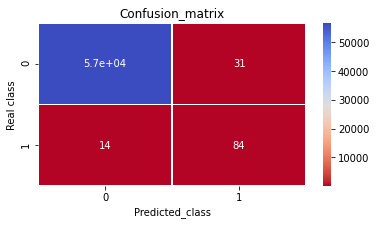

Accuracy: 0.9992099996488887
Confusion matrix: [[56833    31]
 [   14    84]]

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.86      0.79        98

    accuracy                           1.00     56962
   macro avg       0.87      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
fig= plt.figure(figsize=(6,3))# to plot the graph
FP = con_mat_test.sum(axis=0) - np.diag(con_mat_test)  
FN = con_mat_test.sum(axis=1) - np.diag(con_mat_test)
TP = np.diag(con_mat_test)
TN = con_mat_test.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print("TPR for the two class", TPR)
print("TNR for the two class", TNR)
print("FPR for the two class", FPR)
print("FNR for the two class", FNR)
print("TP",con_mat_test[1,1,]) # no of fraud transaction which are predicted fraud
print("TN",con_mat_test[0,0]) # no. of normal transaction which are predited normal
print("FP",con_mat_test[0,1]) # no of normal transaction which are predicted fraud
print("FN",con_mat_test[1,0]) # no of fraud Transaction which are predicted normal
sns.heatmap(con_mat_test,cmap="coolwarm_r",annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()
print("Accuracy:", acc_test)
print("Confusion matrix:", con_mat_test)

print("\n----------Classification Report------------------------------------")
print(classification_report(y_test,ans_test))

## Random Undersampling

### Data Preprocessing

In [ ]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(data = X_test)

#undersample data to achieve 50/50 ratio
rus_50_50 = RandomUnderSampler(sampling_strategy='majority')
X_balanced, y_balanced = rus_50_50.fit_resample(X_train, y_train)
X_balanced = pd.DataFrame(data = X_balanced)
y_balanced = pd.DataFrame(data = y_balanced)

#split data to create validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
to_use = list(range(0,30))

# training set: n = 800
train_X = torch.tensor(X_train.values).float()
train_Y = torch.tensor(y_train.values).long()

# validation set
validation_X = torch.tensor(X_validation.values).float()
validation_Y = torch.tensor(y_validation.values).long()

# prediction set
test_X = torch.tensor(X_test.values).float()

In [ ]:
train_Y = torch.flatten(train_Y)
validation_Y = torch.flatten(validation_Y)

### Baseline Model

In [ ]:
#device = torch.device("cuda")
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} 
# prepare training data loader
train_ds = TensorDataset(train_X,train_Y)
validate_ds = TensorDataset(validation_X,validation_Y)

batch_size = 10
train_dl = DataLoader(train_ds, batch_size, shuffle=True,**kwargs)

validate_dl = DataLoader(validate_ds, batch_size, shuffle=True,**kwargs)

# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        self.fc1 = nn.Linear(input_d,hidden_d)
        self.fc2 = nn.Linear(hidden_d,hidden_d)
        self.fc3 = nn.Linear(hidden_d,output_d)
        #self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        #out = self.dropout1(out)
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return torch.sigmoid(out)

# define dimensions
input_d = len(to_use)
hidden_d = 1
output_d = 2

# set up the model
model = bmodel(input_d, hidden_d, output_d).to(device)

# define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-3)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define the training function
def train(train_loader,model,device,loss_fn,opt):
    model.train()

    losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        #targets = targets.unsqueeze(dim=0)
        
        # generate predictions
        pred = model(inputs)
        
        loss = loss_fn(pred, targets)

        # record loss
        losses.update(loss.data.item())

        # perform gradient descent
        opt.zero_grad()
        loss.backward()
        opt.step()

    return losses.avg

# define the validation function
def validate(val_loader, model, device, loss_fn):
    model.eval()
    with torch.no_grad():
        losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

        for batch_idx, (inputs,targets) in enumerate(val_loader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #targets = targets.unsqueeze(1)
            outputs = model(inputs)
            loss = loss_fn(outputs , targets)

            losses.update(loss.data.item())

    return losses.avg

# define the main function
def fit(num_epochs, model, loss_fn, opt):

    best_loss = 1e9
    is_best = False
    out_train_loss = []
    out_validate_loss = []

    for epoch in range(1,num_epochs+1):
        train_loss = train(train_dl,model,device,loss_fn,opt)
        validation_loss = validate(validate_dl, model,device, loss_fn)

        is_best = validation_loss < best_loss
        best_loss = min(validation_loss,best_loss)

        out_train_loss.append(train_loss)
        out_validate_loss.append(validation_loss)

        if is_best:
            torch.save(model.state_dict(), 'data/best_nn.pt')

        if epoch % 500 == 0:
            print("[%d/%d] training loss: %0.3f, validation loss: %.3f"
                  % (epoch,num_epochs,train_loss,validation_loss))

    print("Best validation loss (%.03f): %.03f" % (epoch,best_loss))
    return out_train_loss, out_validate_loss

#### Train Model

In [ ]:
out_train_loss, out_validate_loss = fit(5000, model, loss_fn, opt)

[500/5000] training loss: 0.442, validation loss: 0.428
[1000/5000] training loss: 0.403, validation loss: 0.394
[1500/5000] training loss: 0.387, validation loss: 0.381
[2000/5000] training loss: 0.379, validation loss: 0.377
[2500/5000] training loss: 0.374, validation loss: 0.373
[3000/5000] training loss: 0.370, validation loss: 0.370
[3500/5000] training loss: 0.367, validation loss: 0.367
[4000/5000] training loss: 0.365, validation loss: 0.365
[4500/5000] training loss: 0.363, validation loss: 0.364
[5000/5000] training loss: 0.362, validation loss: 0.365
Best validation loss (5000.000): 0.362


#### Validation

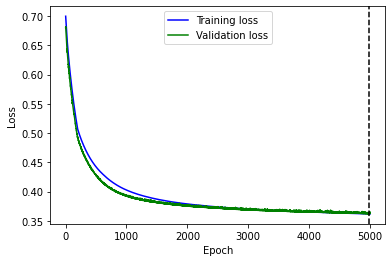

In [ ]:
# plot the training and validation loss: rmse
plot_data = {'Epoch': list(range(1,5001)),
             'TrainLoss': [x for x in out_train_loss],
             'ValidateLoss': [x for x in out_validate_loss] }

plot_data = pd.DataFrame(plot_data)

# find the best epoch
index_min = plot_data['ValidateLoss'].idxmin()

# plot
plt.plot('Epoch','TrainLoss',data=plot_data,color="blue",label='Training loss')
plt.plot('Epoch','ValidateLoss',data=plot_data,color="green",label='Validation loss')
#plt.axhline(y=0.7, color='red', linestyle='-')
plt.axvline(x=index_min+1, color='k', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# prediction in the validation set
model.load_state_dict(torch.load('data/best_nn.pt'))
model.eval()
with torch.no_grad():
    preds = model(validation_X.cpu()) 

ans = []
#Pick the class with maximum weight
for t in preds:
  if t[0]>t[1]:
    ans.append(0)
  else:
    ans.append(1)

In [ ]:
acc = accuracy_score(validation_Y, ans)
print("Accuracy Score: %.3f" % (acc))

Accuracy Score: 0.962


In [ ]:
con_mat = confusion_matrix(validation_Y, ans)
fn_rate = con_mat[1][0] /(con_mat[1][0] + con_mat[1][1])
fp_rate = con_mat[0][1] /(con_mat[0][0] + con_mat[0][1])
print("False Negative Rate: %.3f, False Positive Rate: %.3f" % (fn_rate, fp_rate))

False Negative Rate: 0.036, False Positive Rate: 0.040


In [ ]:
con_mat

array([[72,  3],
       [ 3, 80]])

#### Prediction

In [ ]:
# predict in the prediction set
model.eval()
with torch.no_grad():
    output = model(test_X.cpu())

out_d = pd.DataFrame(output)

ans_test = []
#Pick the class with maximum weight
for t in output:
  if t[0]>t[1]:
    ans_test.append(0)
  else:
    ans_test.append(1)

acc_test = accuracy_score(y_test, ans_test)
print("Accuracy Score: %.3f" % (acc_test))

con_mat_test = confusion_matrix(y_test, ans_test)
fn_rate_test = con_mat_test[1][0] /(con_mat_test[1][0] + con_mat_test[1][1])
fp_rate_test = con_mat_test[0][1] /(con_mat_test[0][0] + con_mat_test[0][1])
print("False Negative Rate: %.3f, False Positive Rate: %.3f" % (fn_rate_test, fp_rate_test))

con_mat_test

Accuracy Score: 0.949
False Negative Rate: 0.061, False Positive Rate: 0.051


array([[53966,  2898],
       [    6,    92]])

### Model Improvements

In [ ]:
#device = torch.device("cuda")
device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} 
# prepare training data loader
train_ds = TensorDataset(train_X,train_Y)
validate_ds = TensorDataset(validation_X,validation_Y)

batch_size = 10
train_dl = DataLoader(train_ds, batch_size, shuffle=True,**kwargs)

validate_dl = DataLoader(validate_ds, batch_size, shuffle=True,**kwargs)

# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        self.fc1 = nn.Linear(input_d,hidden_d)
        self.fc2 = nn.Linear(hidden_d,hidden_d)
        self.fc3 = nn.Linear(hidden_d,output_d)
        self.dropout1 = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))
        out = self.dropout1(out)
        out = self.fc3(out)
        return torch.sigmoid(out)

# define dimensions
input_d = len(to_use)
hidden_d = len(to_use)
output_d = 2

# set up the model
model = bmodel(input_d, hidden_d, output_d).to(device)

# define optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define the training function
def train(train_loader,model,device,loss_fn,opt):
    model.train()

    losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        #targets = targets.unsqueeze(dim=0)
        
        # generate predictions
        pred = model(inputs)
        
        loss = loss_fn(pred, targets)

        # record loss
        losses.update(loss.data.item())

        # perform gradient descent
        opt.zero_grad()
        loss.backward()
        opt.step()

    return losses.avg

# define the validation function
def validate(val_loader, model, device, loss_fn):
    model.eval()
    with torch.no_grad():
        losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

        for batch_idx, (inputs,targets) in enumerate(val_loader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #targets = targets.unsqueeze(1)
            outputs = model(inputs)
            loss = loss_fn(outputs , targets)

            losses.update(loss.data.item())

    return losses.avg

# define the main function
def fit(num_epochs, model, loss_fn, opt):

    best_loss = 1e9
    is_best = False
    out_train_loss = []
    out_validate_loss = []

    for epoch in range(1,num_epochs+1):
        train_loss = train(train_dl,model,device,loss_fn,opt)
        validation_loss = validate(validate_dl, model,device, loss_fn)

        is_best = validation_loss < best_loss
        best_loss = min(validation_loss,best_loss)

        out_train_loss.append(train_loss)
        out_validate_loss.append(validation_loss)

        if is_best:
            torch.save(model.state_dict(), 'data/best_nn1.pt')

        if epoch % 500 == 0:
            print("[%d/%d] training loss: %0.3f, validation loss: %.3f"
                  % (epoch,num_epochs,train_loss,validation_loss))

    print("Best validation loss (%.03f): %.03f" % (epoch,best_loss))
    return out_train_loss, out_validate_loss

#### Train Model

In [ ]:
out_train_loss, out_validate_loss = fit(5000, model, loss_fn, opt)

[500/5000] training loss: 0.329, validation loss: 0.370
[1000/5000] training loss: 0.329, validation loss: 0.378
[1500/5000] training loss: 0.329, validation loss: 0.380
[2000/5000] training loss: 0.329, validation loss: 0.376
[2500/5000] training loss: 0.329, validation loss: 0.364
[3000/5000] training loss: 0.329, validation loss: 0.376
[3500/5000] training loss: 0.329, validation loss: 0.378
[4000/5000] training loss: 0.329, validation loss: 0.372
[4500/5000] training loss: 0.329, validation loss: 0.376
[5000/5000] training loss: 0.329, validation loss: 0.376
Best validation loss (5000.000): 0.362


#### Validation

In [ ]:
# prediction in the validation set
model.load_state_dict(torch.load('data/best_nn1.pt'))
model.eval()
with torch.no_grad():
    preds = model(validation_X.cpu()) 

ans = []
#Pick the class with maximum weight
for t in preds:
  if t[0]>t[1]:
    ans.append(0)
  else:
    ans.append(1)

acc = accuracy_score(validation_Y, ans)
print("Accuracy Score: %.3f" % (acc))

con_mat = confusion_matrix(validation_Y, ans)
fn_rate = con_mat[1][0] /(con_mat[1][0] + con_mat[1][1])
fp_rate = con_mat[0][1] /(con_mat[0][0] + con_mat[0][1])
print("False Negative Rate: %.3f, False Positive Rate: %.3f" % (fn_rate, fp_rate))

Accuracy Score: 0.943
False Negative Rate: 0.072, False Positive Rate: 0.040


#### Prediction

In [ ]:
# predict in the prediction set
model.eval()
with torch.no_grad():
    output = model(test_X.cpu())

out_d = pd.DataFrame(output)

ans_test = []
#Pick the class with maximum weight
for t in output:
  if t[0]>t[1]:
    ans_test.append(0)
  else:
    ans_test.append(1)

acc_test = accuracy_score(y_test, ans_test)
print("Accuracy Score: %.3f" % (acc_test))

con_mat_test = confusion_matrix(y_test, ans_test)
fn_rate_test = con_mat_test[1][0] /(con_mat_test[1][0] + con_mat_test[1][1])
fp_rate_test = con_mat_test[0][1] /(con_mat_test[0][0] + con_mat_test[0][1])
print("False Negative Rate: %.3f, False Positive Rate: %.3f" % (fn_rate_test, fp_rate_test))
con_mat_test

Accuracy Score: 0.965
False Negative Rate: 0.082, False Positive Rate: 0.035


array([[54863,  2001],
       [    8,    90]])

TPR for the two class [0.96481078 0.91836735]
TNR for the two class [0.91836735 0.96481078]
FPR for the two class [0.08163265 0.03518922]
FNR for the two class [0.03518922 0.08163265]
TP 90
TN 54863
FP 2001
FN 8


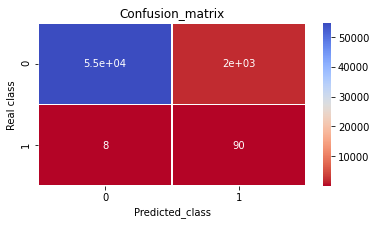

Accuracy: 0.9647308732137214
Confusion matrix: [[54863  2001]
 [    8    90]]

----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962



In [ ]:
fig= plt.figure(figsize=(6,3))# to plot the graph
FP = con_mat_test.sum(axis=0) - np.diag(con_mat_test)  
FN = con_mat_test.sum(axis=1) - np.diag(con_mat_test)
TP = np.diag(con_mat_test)
TN = con_mat_test.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

print("TPR for the two class", TPR)
print("TNR for the two class", TNR)
print("FPR for the two class", FPR)
print("FNR for the two class", FNR)
print("TP",con_mat_test[1,1,]) # no of fraud transaction which are predicted fraud
print("TN",con_mat_test[0,0]) # no. of normal transaction which are predited normal
print("FP",con_mat_test[0,1]) # no of normal transaction which are predicted fraud
print("FN",con_mat_test[1,0]) # no of fraud Transaction which are predicted normal
sns.heatmap(con_mat_test,cmap="coolwarm_r",annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()
print("Accuracy:", acc_test)
print("Confusion matrix:", con_mat_test)

print("\n----------Classification Report------------------------------------")
print(classification_report(y_test,ans_test))